In [1]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-community
!pip install langgraph
!pip install yfinance
!pip install openbb[all]
!pip install together

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
  Attempting uninstall: typer
    Found existing installation: typer 0.16.0
    Uninstalling typer-0.16.0:
      Successfully uninstalled typer-0.16.0


In [1]:
import os, requests, pandas as pd
from datetime import datetime, timedelta,timezone
import re

In [2]:
from getpass import getpass
import os
from openbb import obb

OPENAI_KEY = getpass('Enter Open AI API Key: ')
OPENBB_PAT = getpass('Enter OpenBB Personal Access Token (PAT): ')
# TOGETHERE_KEY = getpass('Enter Together API Key: ')
os.environ['OPENAI_API_KEY'] = OPENAI_KEY

obb.account.login(pat=OPENBB_PAT)


Deprecation Warning: The Account module is deprecated and will be removed in a future version. Please migrate to using the `user_settings.json` file. For more information, visit: https://docs.openbb.co/platform/settings/user_settings/api_keys


In [ ]:
#Creating Financial Data Retrevial Tool

from langchain_core.tools import tool
from datetime import datetime, timedelta

@tool
def get_stock_ticker_symbol(stock_name: str) -> str:
  """Get the symbol, name and CIK for any publicly traded company"""
  res = obb.equity.search(stock_name,provider="sec")
  stock_ticker_details = res.to_df().to_markdown()
  output = """Here are the details of the company and its stock ticker symbol:\n\n""" + stock_ticker_details
  return output

@tool
def get_stock_price_metric(stock_ticker: str) -> str:
  """Get historical stock price data, stock price quote and price performance data
       like price changes for a specific stock ticker"""
  res = obb.equity.price.quote(stock_ticker, provider='cboe')
  price_quote = res.to_df().to_markdown()

  res = obb.equity.price.performance(symbol=stock_ticker, provider='finviz')
  price_performance = res.to_df().to_markdown()

  end_date = datetime.now()
  start_date = (end_date - timedelta(days=182)).strftime("%Y-%m-%d")
  res = obb.equity.price.historical(symbol=stock_ticker, start_date=start_date,
                                    interval='1d', provider='yfinance')
  price_historical = res.to_df().to_markdown()
  output = ("""Here are the stock price metrics and data for the stock ticker symbol """ + stock_ticker + """: \n\n""" +
              "Price Quote Metrics:\n\n" + price_quote +
              "\n\nPrice Performance Metrics:\n\n" + price_performance +
              "\n\nPrice Historical Data:\n\n" + price_historical)
  return output

@tool
def get_stock_fundamental_indicator_metrics(stock_ticker: str) -> str:
    """Get fundamental indicator metrics for a specific stock ticker"""
    res = obb.equity.fundamental.ratios(symbol=stock_ticker, period='annual',
                                        limit=10, provider='yfinance')
    fundamental_ratios = res.to_df().to_markdown()

    res = obb.equity.fundamental.metrics(symbol=stock_ticker, period='annual',
                                        limit=10, provider='yfinance')
    fundamental_metrics = res.to_df().to_markdown()

    res = obb.equity.fundamental.income_growth(symbol=stock_ticker, period='annual',
                                        limit=10, provider='yfinance')
    income_growth = res.to_df().to_markdown()

    output = ("""Here are the fundamental indicator metrics and data for the stock ticker symbol """ + stock_ticker + """: \n\n""" +
              "Fundamental Ratios:\n\n" + fundamental_ratios +
              "\n\nFundamental Metrics:\n\n" + fundamental_metrics+
              "\n\nFundamental Income Growth:\n\n"+income_growth)
    return output

def _clean_summary(text: str, max_len: int = 220) -> str:
    if not text:
        return ""
    # collapse whitespace and trim
    t = re.sub(r"\s+", " ", text).strip()
    return (t[: max_len - 1] + "…") if len(t) > max_len else t
@tool
def get_stock_news(stock_ticker: str) -> str:
    """Get news article headlines for a specific stock ticker via Marketaux (with summary)."""
    try:
        api_key = os.getenv("MARKETAUX_API_KEY")
        if not api_key:
            return "Missing MARKETAUX_API_KEY. Set it as an environment variable."

        base_url = "https://api.marketaux.com/v1/news/all"
        params = {
            "symbols": stock_ticker.upper(),
            "filter_entities": "true",
            "language": "en",
            "api_token": api_key,
            "limit": 50,
            "page": 1,
        }

        articles = []
        while len(articles) < 50:
            r = requests.get(base_url, params=params, timeout=20)
            r.raise_for_status()
            payload = r.json()

            data = payload.get("data", []) or []
            if not data:
                break

            articles.extend(data)
            meta = payload.get("meta", {}) or {}
            if not meta.get("has_next_page"):
                break
            params["page"] += 1

        if not articles:
            return f"Sorry, I couldn’t find recent news for {stock_ticker.upper()}."

        rows = []
        for a in articles[:50]:
            # symbols live under `entities`
            ents = a.get("entities") or []
            syms = ",".join(e.get("symbol", "") for e in ents if e.get("symbol")) or stock_ticker.upper()

            summary = a.get("snippet") or a.get("description") or a.get("content") or ""
            summary = _clean_summary(summary, max_len=500)

            rows.append({
                "symbols": syms,
                "title": (a.get("title") or "").strip(),
                "summary": summary,
                "source": a.get("source") or "",
                "published_at": a.get("published_at") or "",
                "url": a.get("url") or "",
            })

        # Sort newest first if we have timestamps
        df = pd.DataFrame(rows)
        if "published_at" in df.columns and not df["published_at"].isna().all():
            df = df.sort_values("published_at", ascending=False)

        # Show more than just title
        news = df[["symbols", "title", "summary","url"]].to_markdown(index=False)

        return (
            f"Here are the recent news headlines for the stock ticker symbol {stock_ticker.upper()}:\n\n{news}\n\n"
            "Tip: each row also has `url` if you want to open the article."
        )

    except Exception as e:
        return f"Sorry, I could not retrieve news for the stock ticker symbol {stock_ticker.upper()}: {e}"
@tool
def get_general_market_data() -> str:
    """Get general data and indicators for the whole stock market including,
       most actively traded stocks based on volume, top price gainers and top price losers.
       Useful when you want an overview of the market and what stocks to look at."""

    res = obb.equity.discovery.active(sort='desc', provider='yfinance', limit=15)
    most_active_stocks = res.to_df().to_markdown()

    res = obb.equity.discovery.gainers(sort='desc', provider='yfinance', limit=15)
    price_gainers = res.to_df().to_markdown()


    res = obb.equity.discovery.losers(sort='desc', provider='yfinance', limit=15)
    price_losers = res.to_df().to_markdown()


    res = obb.equity.discovery.undervalued_growth(sort='desc', provider='yfinance', limit=15)
    undervalued_growth = res.to_df().to_markdown()

    output = ("""Here's some detailed information of the stock market which includes most actively traded stocks, gainers and losers:\n\n""" +
              "Most actively traded stocks:\n\n" + most_active_stocks +
              "\n\nTop price gainers:\n\n" + price_gainers +
              "\n\nTop price losers:\n\n" + price_losers+
              "\n\nUnderValue Growth:\n\n"+undervalued_growth)
    return output


In [8]:
response = get_stock_news.invoke({"stock_ticker": "GOOGL"})
print(response)

Here are the recent news headlines for the stock ticker symbol GOOGL:

| symbols   | title                                                                                                                                                                          | summary                                                                                                                                                         | url                                                                                                                                                       |
|:----------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------

In [4]:
from IPython.display import display, Markdown

response = get_general_market_data.invoke({})
display(Markdown(response))

Here's some detailed information of the stock market which includes most actively traded stocks, gainers and losers:

Most actively traded stocks:

|    | symbol   | name                            |   price |     change |   percent_change |    volume |    open |     high |     low |   previous_close |     ma50 |    ma200 |   year_high |   year_low |   market_cap |   shares_outstanding |   book_value |   price_to_book |   eps_ttm |   eps_forward |   pe_forward |   dividend_yield | exchange   | exchange_timezone   | earnings_date             | currency   |
|---:|:---------|:--------------------------------|--------:|-----------:|-----------------:|----------:|--------:|---------:|--------:|-----------------:|---------:|---------:|------------:|-----------:|-------------:|---------------------:|-------------:|----------------:|----------:|--------------:|-------------:|-----------------:|:-----------|:--------------------|:--------------------------|:-----------|
|  0 | NVDA     | NVIDIA Corporation              |  167.03 | -4.35001   |      -0.0253822  | 183423362 | 171.22  | 171.35   | 164.58  |           171.38 | 147.391  | 132.907  |     174.25  |      86.62 |  4.07346e+12 |          2.43876e+10 |        3.438 |       48.5835   |      3.1  |          4.12 |     40.5413  |      0.000233399 | NMS        | America/New_York    | 2025-08-27 16:00:00-04:00 | USD        |
|  1 | NIO      | NIO Inc.                        |    5.01 |  0.49      |       0.108407   | 129373078 |   4.645 |   5.09   |   4.64  |             4.52 |   3.7778 |   4.3655 |       7.71  |       3.02 |  1.10067e+10 |          2.09749e+09 |       -0.175 |      -28.6286   |     -1.64 |         -0.85 |     -5.89412 |      0           | NYQ        | America/New_York    | 2025-06-03 07:22:43-04:00 | USD        |
|  2 | F        | Ford Motor Company              |   11.19 | -0.120001  |      -0.0106102  |  74286639 |  11.24  |  11.29   |  11.08  |            11.31 |  10.8092 |  10.3119 |      13.88  |       8.44 |  4.44976e+10 |          3.9057e+09  |       11.225 |        0.996882 |      1.25 |          1.75 |      6.39429 |      0.0530504   | NYQ        | America/New_York    | 2025-07-30 16:00:00-04:00 | USD        |
|  3 | PLTR     | Palantir Technologies Inc.      |  149.07 | -2.71999   |      -0.0179194  |  49323377 | 150.85  | 151.79   | 145.062 |           151.79 | 134.854  |  91.9637 |     155.68  |      21.23 |  3.51792e+11 |          2.26291e+09 |        2.299 |       64.8412   |      0.23 |          0.47 |    317.17    |      0           | NMS        | America/New_York    | 2025-08-04 16:00:00-04:00 | USD        |
|  4 | AMD      | Advanced Micro Devices, Inc.    |  154.72 | -2.28      |      -0.0145223  |  48277494 | 156.2   | 156.227  | 149.34  |           157    | 128.47   | 123.378  |     174.05  |      76.48 |  2.50863e+11 |          1.6214e+09  |       35.817 |        4.31974  |      1.37 |          5.1  |     30.3373  |      0           | NMS        | America/New_York    | 2025-08-05 16:00:00-04:00 | USD        |
|  5 | AAPL     | Apple Inc.                      |  214.4  |  1.92      |       0.00903614 |  44917713 | 213.235 | 214.645  | 212.23  |           212.48 | 205.013  | 222.213  |     260.1   |     169.21 |  3.20224e+12 |          1.49358e+10 |        4.471 |       47.9535   |      6.42 |          8.31 |     25.8002  |      0.00470633  | NMS        | America/New_York    | 2025-07-31 16:00:00-04:00 | USD        |
|  6 | PFE      | Pfizer, Inc.                    |   25.14 |  0.879999  |       0.0362737  |  43245563 |  24.37  |  25.14   |  24.35  |            24.26 |  24.0454 |  25.4994 |      31.54  |      20.92 |  1.4293e+11  |          5.68537e+09 |       15.891 |        1.58203  |      1.38 |          2.93 |      8.5802  |      0.069662    | NYQ        | America/New_York    | 2025-08-05 08:30:00-04:00 | USD        |
|  7 | T        | AT&T Inc.                       |   27.42 |  0.0400009 |       0.00146095 |  29588369 |  27.45  |  27.76   |  27.22  |            27.38 |  27.7244 |  25.2521 |      29.19  |      18.64 |  1.97444e+11 |          7.20074e+09 |       14.418 |        1.90179  |      1.63 |          2.24 |     12.2411  |      0.0405405   | NYQ        | America/New_York    | 2025-07-23 08:30:00-04:00 | USD        |
|  8 | BAC      | Bank of America Corporation     |   47.77 |  0.290001  |       0.00610785 |  28240376 |  47.6   |  48.17   |  47.465 |            47.48 |  45.5368 |  43.8481 |      49.31  |      33.07 |  3.5525e+11  |          7.43668e+09 |       37.127 |        1.28666  |      3.41 |          3.66 |     13.0519  |      0.021904    | NYQ        | America/New_York    | 2025-10-15 08:30:00-04:00 | USD        |
|  9 | CCL      | Carnival Corporation            |   29.89 |  0.0999985 |       0.00335678 |  11784720 |  29.96  |  30.07   |  29.25  |            29.79 |  25.3774 |  23.3627 |      30.46  |      13.78 |  4.05272e+10 |          1.1674e+09  |        7.627 |        3.91897  |      1.91 |          1.72 |     17.3779  |      0           | NYQ        | America/New_York    | 2025-06-24 08:30:00-04:00 | USD        |
| 10 | MRK      | Merck & Company, Inc.           |   81.61 |  2.3       |       0.0290002  |  10551662 |  79.87  |  81.765  |  79.87  |            79.31 |  79.3616 |  91.2103 |     128.73  |      73.31 |  2.04925e+11 |          2.51103e+09 |       19.21  |        4.24831  |      6.88 |          9.4  |      8.68192 |      0.0393393   | NYQ        | America/New_York    | 2025-07-29 08:30:00-04:00 | USD        |
| 11 | AFRM     | Affirm Holdings, Inc.           |   65.43 | -1.32      |      -0.0197753  |   5155686 |  66.38  |  66.75   |  63.676 |            66.75 |  60.1431 |  56.514  |      82.527 |      22.25 |  2.11077e+10 |          2.81826e+08 |        8.914 |        7.34014  |     -0.19 |          0.47 |    139.213   |      0           | NMS        | America/New_York    | 2025-05-08 16:00:00-04:00 | USD        |
| 12 | ALIT     | Alight, Inc.                    |    5.58 |  0.14      |       0.0257353  |   4541320 |   5.45  |   5.61   |   5.445 |             5.44 |   5.57   |   6.3759 |       8.925 |       4.49 |  3.06039e+09 |          5.27835e+08 |        7.951 |        0.701798 |     -0.06 |          0.57 |      9.78947 |      0.0147059   | NYQ        | America/New_York    | 2025-08-05 08:30:00-04:00 | USD        |
| 13 | EDU      | New Oriental Education & Techno |   47.59 |  0.860001  |       0.0184036  |   1782498 |  46.69  |  47.99   |  46.055 |            46.73 |  49.3244 |  54.0783 |      87.26  |      40.66 |  8.20128e+09 |          1.63529e+08 |       22.855 |        2.08226  |      2.3  |          4.32 |     11.0162  |      0           | NYQ        | America/New_York    | 2025-04-23 05:33:59-04:00 | USD        |
| 14 | GSAT     | Globalstar, Inc.                |   25.88 | -0.1       |      -0.00384913 |    538710 |  25.99  |  26.2461 |  25.55  |            25.98 |  22.3562 |  23.3233 |      41.1   |      15    |  3.27597e+09 |          1.26583e+08 |        2.72  |        9.51471  |     -0.62 |          0    |    nan       |      0           | NMS        | America/New_York    | 2025-05-08 16:15:00-04:00 | USD        |

Top price gainers:

|    | symbol   | name                           |   price |   change |   percent_change |    volume |   open |     high |      low |   previous_close |     ma50 |     ma200 |   year_high |   year_low |   market_cap |   shares_outstanding |   book_value |   price_to_book |   eps_ttm |   eps_forward |   pe_forward |   dividend_yield | exchange   | exchange_timezone   | earnings_date             | currency   |
|---:|:---------|:-------------------------------|--------:|---------:|-----------------:|----------:|-------:|---------:|---------:|-----------------:|---------:|----------:|------------:|-----------:|-------------:|---------------------:|-------------:|----------------:|----------:|--------------:|-------------:|-----------------:|:-----------|:--------------------|:--------------------------|:-----------|
|  0 | MEDP     | Medpace Holdings, Inc.         |  477.73 |   168.85 |         0.546652 |   4469214 | 444    | 501.3    | 436.01   |           308.88 | 310.708  | 325.582   |      501.3  |     250.05 |  1.37307e+10 |          2.87416e+07 |       27.013 |       17.6852   |     13.47 |         12.49 |     38.249   |        0         | NMS        | America/New_York    | 2025-07-21 16:00:00-04:00 | USD        |
|  1 | KSS      | Kohl's Corporation             |   14.34 |     3.92 |         0.3762   | 207625689 |  19.75 |  21.39   |  12.3744 |            10.42 |   8.7198 |  12.0086  |       22.53 |       6.04 |  1.60668e+09 |          1.12042e+08 |       33.741 |        0.425002 |      1.09 |          2    |      7.17    |        0.119962  | NYQ        | America/New_York    | 2025-05-29 07:00:00-04:00 | USD        |
|  2 | FTRE     | Fortrea Holdings Inc.          |    5.8  |     1.14 |         0.244635 |   2930461 |   5    |   5.9881 |   4.935  |             4.66 |   4.9879 |  12.4165  |       27.99 |       3.97 |  5.25134e+08 |          9.05403e+07 |        9.49  |        0.61117  |     -8.39 |          1.31 |      4.42748 |        0         | NMS        | America/New_York    | 2025-08-06 08:30:00-04:00 | USD        |
|  3 | DNA      | Ginkgo Bioworks Holdings, Inc. |   13.35 |     2.03 |         0.179329 |   3615449 |  11.34 |  13.55   |  11.28   |            11.32 |   9.0302 |   8.98555 |       16.85 |       5    |  7.81401e+08 |          4.63446e+07 |       11.836 |        1.12791  |     -8.91 |         -7.97 |     -1.67503 |        0         | NYQ        | America/New_York    | 2025-05-06 17:00:06-04:00 | USD        |
|  4 | IQV      | IQVIA Holdings, Inc.           |  187.38 |    28.42 |         0.178787 |   6854913 | 171.33 | 190.13   | 170.16   |           158.96 | 153.688  | 183.474   |      252.88 |     134.65 |  3.24167e+10 |          1.73e+08    |       34.331 |        5.45804  |      7.33 |         12.07 |     15.5244  |        0         | NYQ        | America/New_York    | 2025-07-22 08:30:00-04:00 | USD        |
|  5 | DHI      | D.R. Horton, Inc.              |  153.5  |    22.28 |         0.169791 |  13088202 | 144.63 | 153.75   | 141.085  |           131.22 | 126.705  | 141.041   |      199.85 |     110.44 |  4.71523e+10 |          3.07181e+08 |       78.823 |        1.9474   |     13.19 |         15.93 |      9.63591 |        0.0106691 | NYQ        | America/New_York    | 2025-07-22 08:30:00-04:00 | USD        |
|  6 | DQ       | DAQO New Energy Corp.          |   24.6  |     3.54 |         0.168091 |   4732691 |  22.24 |  25.46   |  22.26   |            21.06 |  15.8036 |  18.1852  |       30.85 |      12.41 |  1.64959e+09 |          6.70567e+07 |       64.675 |        0.380363 |     -6.51 |         -1.28 |    -19.2188  |        0         | NYQ        | America/New_York    | 2025-04-29 07:16:33-04:00 | USD        |
|  7 | LGIH     | LGI Homes, Inc.                |   59.16 |     8.07 |         0.157957 |    655221 |  52.95 |  59.5738 |  52.95   |            51.09 |  52.6446 |  78.2403  |      125.83 |      47.17 |  1.38461e+09 |          2.34045e+07 |       87.271 |        0.677888 |      7.75 |         10.69 |      5.53414 |        0         | NMS        | America/New_York    | 2025-08-05 08:30:00-04:00 | USD        |
|  8 | ICLR     | ICON plc                       |  161.5  |    21.87 |         0.156628 |   4110535 | 150    | 161.68   | 150      |           139.63 | 141.327  | 186.596   |      338.8  |     125.1  |  1.28366e+10 |          7.94838e+07 |      119.561 |        1.35078  |      9.17 |         15.07 |     10.7167  |        0         | NMS        | America/New_York    | 2025-07-23 16:00:00-04:00 | USD        |
|  9 | VLRS     | Controladora Vuela Compania de |    5.1  |     0.69 |         0.156463 |   2058633 |   4.47 |   5.11   |   4.48   |             4.41 |   4.5546 |   6.263   |        9    |       3.49 |  6.03299e+08 |          1.15003e+08 |        0.317 |       16.0883   |     -6.32 |          1    |      5.1     |        0         | NYQ        | America/New_York    | 2025-07-21 16:00:00-04:00 | USD        |
| 10 | HOV      | Hovnanian Enterprises, Inc.    |  121.85 |    14.24 |         0.13233  |    183157 | 111.25 | 123.41   | 114.5    |           107.61 | 103.226  | 130.153   |      240.34 |      81.15 |  6.17641e+08 |          5.06886e+06 |      118.152 |        1.0313   |     28.24 |          0.72 |    169.236   |        0         | NYQ        | America/New_York    | 2025-05-20 09:15:48-04:00 | USD        |
| 11 | DFH      | Dream Finders Homes, Inc.      |   28.7  |     3.29 |         0.129477 |    918117 |  26.07 |  28.7092 |  25.95   |            25.41 |  24.0218 |  25.6035  |       39.15 |      19.65 |  2.685e+09   |          3.58279e+07 |       13.784 |        2.08212  |      3.33 |          3.36 |      8.54167 |        0         | NYQ        | America/New_York    | 2025-05-06 07:00:00-04:00 | USD        |
| 12 | TXG      | 10x Genomics, Inc.             |   12.99 |     1.45 |         0.12565  |   3769291 |  11.73 |  13.04   |  11.6    |            11.54 |  10.6296 |  12.4803  |       24.76 |       6.78 |  1.59951e+09 |          1.11093e+08 |        5.741 |        2.26267  |     -1.3  |         -1.22 |    -10.6475  |        0         | NMS        | America/New_York    | 2025-08-07 16:00:00-04:00 | USD        |
| 13 | AMR      | Alpha Metallurgical Resources, |  141.35 |    15.28 |         0.121203 |    808143 | 134.9  | 145.42   | 133.99   |           126.07 | 115.033  | 164.417   |      308.88 |      97.41 |  1.845e+09   |          1.30527e+07 |      123.717 |        1.14253  |      2.04 |         35.48 |      3.98393 |        0         | NYQ        | America/New_York    | 2025-08-08 08:30:00-04:00 | USD        |
| 14 | XRX      | Xerox Holdings Corporation     |    5.83 |     0.63 |         0.121154 |   4730851 |   5.21 |   5.88   |   5.21   |             5.2  |   5.2788 |   7.0611  |       12.04 |       3.45 |  7.33356e+08 |          1.2579e+08  |        8.372 |        0.696369 |    -10.56 |          1.22 |      4.77869 |        0.168269  | NMS        | America/New_York    | 2025-05-01 06:30:00-04:00 | USD        |

Top price losers:

|    | symbol   | name                            |   price |     change |   percent_change |   volume |   open |     high |     low |   previous_close |     ma50 |    ma200 |   year_high |   year_low |   market_cap |   shares_outstanding |   book_value |   price_to_book |   eps_ttm |   eps_forward |   pe_forward |   dividend_yield | exchange   | exchange_timezone   | earnings_date             | currency   |
|---:|:---------|:--------------------------------|--------:|-----------:|-----------------:|---------:|-------:|---------:|--------:|-----------------:|---------:|---------:|------------:|-----------:|-------------:|---------------------:|-------------:|----------------:|----------:|--------------:|-------------:|-----------------:|:-----------|:--------------------|:--------------------------|:-----------|
|  0 | UTI      | Universal Technical Institute I |   31.17 |  -0.890001 |       -0.0277605 |   556403 |  32.06 |  32.305  |  31.11  |            32.06 |  33.5306 |  26.7926 |      36.32  |      15.14 |  1.69584e+09 |          5.44062e+07 |        5.402 |         5.77009 |      1.05 |          0.93 |      33.5161 |      0           | NYQ        | America/New_York    | 2025-08-06 16:00:00-04:00 | USD        |
|  1 | FN       | Fabrinet                        |  300.79 |  -8.70999  |       -0.0281421 |   572919 | 308.03 | 310.69   | 292.56  |           309.5  | 260.162  | 232.718  |     314.47  |     148.55 |  1.07775e+10 |          3.58307e+07 |       53.228 |         5.65097 |      8.98 |         11.07 |      27.1716 |      0           | NYQ        | America/New_York    | 2025-05-05 16:15:00-04:00 | USD        |
|  2 | PI       | Impinj, Inc.                    |  113.23 |  -3.28     |       -0.0281521 |   688668 | 115.35 | 116.51   | 107.42  |           116.51 | 113.904  | 132.673  |     239.88  |      60.85 |  3.28176e+09 |          2.89831e+07 |        5.551 |        20.3981  |     -0.06 |          2.75 |      41.1745 |      0           | NMS        | America/New_York    | 2025-07-30 16:00:00-04:00 | USD        |
|  3 | AMAT     | Applied Materials, Inc.         |  187.14 |  -5.47     |       -0.0283994 |  6965751 | 192.27 | 192.5    | 185.13  |           192.61 | 176.206  | 171.058  |     217.77  |     123.74 |  1.50179e+11 |          8.02498e+08 |       23.627 |         7.9206  |      8.22 |          9.69 |      19.3127 |      0.00861845  | NMS        | America/New_York    | 2025-05-15 16:01:24-04:00 | USD        |
|  4 | IMOS     | ChipMOS TECHNOLOGIES INC.       |   17.69 |  -0.519999 |       -0.0285557 |    17015 |  17.7  |  17.79   |  17.35  |            18.21 |  18.7534 |  19.091  |      24.88  |      12.78 |  6.26346e+08 |          3.54068e+07 |       34.777 |         0.50867 |      1.33 |          1.01 |      17.5149 |      0.0658979   | NMS        | America/New_York    | 2025-05-13 03:00:05-04:00 | USD        |
|  5 | ONTO     | Onto Innovation Inc.            |   96.79 |  -2.85     |       -0.028603  |   982668 |  99.72 |  99.95   |  95.225 |            99.64 |  97.8246 | 148.615  |     228.42  |      85.88 |  4.73655e+09 |          4.89364e+07 |       39.307 |         2.46241 |      4.42 |          6.71 |      14.4247 |      0           | NYQ        | America/New_York    | 2025-08-07 16:00:00-04:00 | USD        |
|  6 | COHR     | Coherent Corp.                  |   97.02 |  -2.86     |       -0.0286344 |  2809843 |  99.93 |  99.78   |  94.58  |            99.88 |  84.448  |  85.7774 |     113.6   |      45.58 |  1.50809e+10 |          1.55441e+08 |       34.456 |         2.81576 |     -0.22 |          4.36 |      22.2523 |      0           | NYQ        | America/New_York    | 2025-05-07 16:15:00-04:00 | USD        |
|  7 | CRVL     | CorVel Corp.                    |   93.28 |  -2.75     |       -0.0286369 |   168786 |  96.27 |  97.43   |  93.005 |            96.03 | 105.598  | 110.334  |     128.61  |      92.23 |  4.79841e+09 |          5.14409e+07 |        6.269 |        14.8796  |      1.83 |        nan    |     nan      |      0           | NMS        | America/New_York    | 2025-05-22 06:15:00-04:00 | USD        |
|  8 | CRDO     | Credo Technology Group Holding  |   92.93 |  -2.81     |       -0.0293503 |  4821756 |  93.22 |  95.2978 |  88.42  |            95.74 |  78.6368 |  59.6433 |     104.35  |      22.5  |  1.59507e+10 |          1.71642e+08 |        3.982 |        23.3375  |      0.29 |          0.77 |     120.688  |      0           | NMS        | America/New_York    | 2025-06-02 16:05:00-04:00 | USD        |
|  9 | CCBG     | Capital City Bank Group         |   40.71 |  -1.24     |       -0.029559  |    92489 |  40.4  |  42.135  |  40.4   |            41.95 |  38.8474 |  37.0239 |      42.33  |      30.99 |  6.94305e+08 |          1.70549e+07 |       30.055 |         1.35452 |      3.37 |          2.92 |      13.9418 |      0.0216925   | NMS        | America/New_York    | 2025-07-22 08:30:00-04:00 | USD        |
| 10 | ROAD     | Construction Partners, Inc.     |  103.52 |  -3.16     |       -0.0296213 |   566737 | 105.83 | 105.83   | 100.586 |           106.68 | 104.694  |  88.0815 |     114.735 |      51.63 |  5.80033e+09 |          4.72172e+07 |       14.414 |         7.18191 |      1.16 |          1.9  |      54.4842 |      0           | NMS        | America/New_York    | 2025-08-07 08:30:00-04:00 | USD        |
| 11 | VIV      | Telefonica Brasil S.A.          |   10.79 |  -0.33     |       -0.0296763 |  1769206 |  11.15 |  11.15   |  10.79  |            11.12 |  10.642  |   9.2655 |      11.96  |       7.47 |  1.74604e+10 |          1.61327e+09 |       21.011 |         0.51354 |      0.62 |          0.76 |      14.1974 |      0.0661871   | NYQ        | America/New_York    | 2025-07-28 15:00:00-04:00 | USD        |
| 12 | GEV      | GE Vernova Inc.                 |  548.99 | -16.92     |       -0.0298987 |  3923414 | 558.51 | 558.19   | 537.155 |           565.91 | 494.04   | 373.127  |     581.265 |     150.01 |  1.49839e+11 |          2.72935e+08 |       31.535 |        17.4089  |      6.96 |          6.9  |      79.5638 |      0.000883533 | NYQ        | America/New_York    | 2025-07-23 08:30:00-04:00 | USD        |
| 13 | SARO     | StandardAero, Inc.              |   28.87 |  -0.889999 |       -0.0299059 |  1776106 |  29.61 |  29.79   |  28.67  |            29.76 |  29.9428 |  28.0837 |      34.38  |      21.31 |  9.65592e+09 |          3.34462e+08 |        7.289 |         3.96076 |      0.21 |          0.83 |      34.7831 |      0           | NYQ        | America/New_York    | 2025-05-12 16:15:00-04:00 | USD        |
| 14 | SMTC     | Semtech Corporation             |   51.47 |  -1.59     |       -0.0299661 |  1341275 |  52.61 |  52.79   |  50.15  |            53.06 |  42.3648 |  46.1037 |      79.52  |      24.05 |  4.45913e+09 |          8.66356e+07 |        6.567 |         7.83767 |     -1.68 |          1.65 |      31.1939 |      0           | NMS        | America/New_York    | 2025-05-27 16:00:00-04:00 | USD        |

UnderValue Growth:

|    | symbol   | name                     |   price |     change |   percent_change |   volume |   open |   high |     low |   previous_close |    ma50 |    ma200 |   year_high |   year_low |   market_cap |   shares_outstanding |   book_value |   price_to_book |   eps_ttm |   eps_forward |   pe_forward |   dividend_yield | exchange   | exchange_timezone   | earnings_date             | currency   |
|---:|:---------|:-------------------------|--------:|-----------:|-----------------:|---------:|-------:|-------:|--------:|-----------------:|--------:|---------:|------------:|-----------:|-------------:|---------------------:|-------------:|----------------:|----------:|--------------:|-------------:|-----------------:|:-----------|:--------------------|:--------------------------|:-----------|
|  0 | IAG      | Iamgold Corporation      |    7.46 |  0.27      |       0.0375522  | 18465783 |  7.27  |  7.51  |  7.1605 |             7.19 |  7.0872 |  6.16635 |        8.38 |      3.44  |  4.28987e+09 |          5.7505e+08  |        5.9   |        1.26441  |      1.46 |          0.8  |      9.325   |       0          | NYQ        | America/New_York    | 2025-08-07 16:00:00-04:00 | USD        |
|  1 | DOLE     | Dole plc                 |   14.24 |  0.51      |       0.037145   |   724935 | 13.76  | 14.24  | 13.75   |            13.73 | 14.0142 | 14.4138  |       17.12 |     12.204 |  1.35477e+09 |          9.5138e+07  |       14.062 |        1.01266  |      1.28 |          1.42 |     10.0282  |       0.0236708  | NYQ        | America/New_York    | 2025-08-11 08:30:00-04:00 | USD        |
|  2 | KOS      | Kosmos Energy Ltd.       |    2.03 |  0.0699999 |       0.0357142  |  4139069 |  1.96  |  2.05  |  1.96   |             1.96 |  1.9242 |  2.79485 |        5.66 |      1.39  |  9.70358e+08 |          4.78009e+08 |        2.298 |        0.883377 |     -0.03 |          0.67 |      3.02985 |       0          | NYQ        | America/New_York    | 2025-08-04 08:30:00-04:00 | USD        |
|  3 | MTCH     | Match Group, Inc.        |   33.82 |  1.15      |       0.0352005  |  5351882 | 32.8   | 33.98  | 32.77   |            32.67 | 30.9474 | 32.2956  |       38.84 |     26.39  |  8.29351e+09 |          2.45225e+08 |       -0.735 |      -46.0136   |      2.02 |          2.48 |     13.6371  |       0.0116315  | NMS        | America/New_York    | 2025-08-05 16:00:00-04:00 | USD        |
|  4 | KGC      | Kinross Gold Corporation |   16.4  |  0.48      |       0.0301507  | 21127133 | 16.04  | 16.52  | 15.92   |            15.92 | 15.1392 | 12.1557  |       16.52 |      7.84  |  2.01195e+10 |          1.2268e+09  |        5.853 |        2.80198  |      0.98 |          0.88 |     18.6364  |       0.00753769 | NYQ        | America/New_York    | 2025-07-30 16:00:00-04:00 | USD        |
|  5 | NOV      | NOV Inc.                 |   13.02 |  0.31      |       0.0243903  |  3635276 | 12.73  | 13.105 | 12.685  |            12.71 | 12.8918 | 14.294   |       21.2  |     10.84  |  4.89211e+09 |          3.75738e+08 |       17.033 |        0.764398 |      1.49 |          1.56 |      8.34615 |       0.0236035  | NYQ        | America/New_York    | 2025-07-28 16:00:00-04:00 | USD        |
|  6 | APA      | APA Corporation          |   18.74 |  0.389999  |       0.0212534  |  5834282 | 18.44  | 18.9   | 18.44   |            18.35 | 18.5958 | 20.7709  |       33.41 |     13.58  |  6.76223e+09 |          3.60845e+08 |       15.04  |        1.24601  |      2.79 |          2.75 |      6.81454 |       0.0544959  | NMS        | America/New_York    | 2025-08-06 16:00:00-04:00 | USD        |
|  7 | SYF      | Synchrony Financial      |   70.66 |  1.22      |       0.0175691  |  5724139 | 68.775 | 71.28  | 68.19   |            69.44 | 63.3088 | 60.4659  |       71.88 |     40.545 |  2.68972e+10 |          3.80657e+08 |       40.361 |        1.7507   |      7.3  |          6.47 |     10.9212  |       0.0144009  | NYQ        | America/New_York    | 2025-07-22 08:30:00-04:00 | USD        |
|  8 | MET      | MetLife, Inc.            |   77.51 |  1.18      |       0.0154592  |  2129563 | 76.42  | 77.6   | 76.19   |            76.33 | 78.9228 | 80.9605  |       89.05 |     65.21  |  5.20323e+10 |          6.71298e+08 |       40.834 |        1.89817  |      6.12 |          9.69 |      7.99897 |       0.0285602  | NYQ        | America/New_York    | 2025-08-06 16:00:00-04:00 | USD        |
|  9 | AGNC     | AGNC Investment Corp.    |    9.37 |  0.14      |       0.015168   | 30654467 |  9.186 |  9.475 |  9.115  |             9.23 |  9.186  |  9.54085 |       10.85 |      7.85  |  9.56096e+09 |          1.02038e+09 |        9.057 |        1.03456  |      0.36 |          1.73 |      5.41618 |       0          | NMS        | America/New_York    | 2025-07-21 16:00:00-04:00 | USD        |
| 10 | ET       | Energy Transfer LP       |   17.33 |  0.0900002 |       0.00522043 | 12069548 | 17.2   | 17.38  | 17.14   |            17.24 | 17.793  | 18.1595  |       21.45 |     14.6   |  5.94727e+10 |          3.43178e+09 |        9.158 |        1.89233  |      1.32 |          1.58 |     10.9684  |       0.075116   | NYQ        | America/New_York    | 2025-08-06 16:00:00-04:00 | USD        |
| 11 | BKR      | Baker Hughes Company     |   40.02 |  0.170002  |       0.00426605 | 12994575 | 39.91  | 40.24  | 39.615  |            39.85 | 38.3718 | 40.7732  |       49.4  |     32.25  |  3.96498e+10 |          9.9075e+08  |       17.208 |        2.32566  |      2.93 |          2.57 |     15.572   |       0.0215809  | NMS        | America/New_York    | 2025-07-22 16:00:00-04:00 | USD        |
| 12 | MAT      | Mattel, Inc.             |   19.89 |  0.0100002 |       0.00050303 |  4849813 | 19.95  | 20.33  | 19.88   |            19.88 | 19.4326 | 18.9187  |       22.07 |     13.95  |  6.42274e+09 |          3.22913e+08 |        6.595 |        3.01592  |      1.54 |          1.59 |     12.5094  |       0          | NMS        | America/New_York    | 2025-07-23 16:00:00-04:00 | USD        |
| 13 | LAUR     | Laureate Education, Inc. |   22.95 | -0.039999  |      -0.00173984 |  1045974 | 23.01  | 23.17  | 22.7081 |            22.99 | 22.8263 | 19.7528  |       24.57 |     13.6   |  3.41519e+09 |          1.4881e+08  |        6.105 |        3.75921  |      1.86 |          1.41 |     16.2766  |       0          | NMS        | America/New_York    | 2025-07-31 08:30:00-04:00 | USD        |
| 14 | GM       | General Motors Company   |   48.89 | -4.32      |      -0.0811877  | 31487669 | 51.72  | 52.08  | 48.87   |            53.21 | 50.0232 | 49.9534  |       61.24 |     38.96  |  4.70046e+10 |          9.61435e+08 |       66.638 |        0.733665 |      7.16 |         10.57 |      4.62535 |       0.00902086 | NYQ        | America/New_York    | 2025-07-22 08:30:00-04:00 | USD        |

In [36]:
# from langchain_community.llms import Together

# llm_raw = Together(
#     model="meta-llama/Llama-3-8b-chat-hf",
#     temperature=0.0
# )

tools = [get_stock_ticker_symbol,
         get_stock_price_metric,
         get_stock_fundamental_indicator_metrics,
         get_stock_news,
         get_general_market_data]


tools

[StructuredTool(name='get_stock_ticker_symbol', description='Get the symbol, name and CIK for any publicly traded company', args_schema=<class 'langchain_core.utils.pydantic.get_stock_ticker_symbol'>, func=<function get_stock_ticker_symbol at 0x000002857F032020>),
 StructuredTool(name='get_stock_price_metric', description='Get historical stock price data, stock price quote and price performance data\n       like price changes for a specific stock ticker', args_schema=<class 'langchain_core.utils.pydantic.get_stock_price_metric'>, func=<function get_stock_price_metric at 0x0000028503B57CE0>),
 StructuredTool(name='get_stock_fundamental_indicator_metrics', description='Get fundamental indicator metrics for a specific stock ticker', args_schema=<class 'langchain_core.utils.pydantic.get_stock_fundamental_indicator_metrics'>, func=<function get_stock_fundamental_indicator_metrics at 0x0000028503B54D60>),
 StructuredTool(name='get_stock_news', description='Get news article headlines for a sp

In [37]:
from langchain_core.messages import SystemMessage

AGENT_PREFIX = """Role: You are an AI stock market assistant tasked with providing investors
with up-to-date, detailed information on individual stocks or advice based on general market data.

Objective: Assist data-driven stock market investors by giving accurate,
complete, but concise information relevant to their questions about individual
stocks or general advice on useful stocks based on general market data and trends.

Capabilities: You are given a number of tools as functions. Use as many tools
as needed to ensure all information provided is timely, accurate, concise,
relevant, and responsive to the user's query.

Starting Flow:
Input validation. Determine if the input is asking about a specific company
or stock ticker (Flow 2). If not, check if they are asking for general advice on potentially useful stocks
based on current market data (Flow 1). Otherwise, respond in a friendly, positive, professional tone
that you don't have information to answer as you can only provide financial advice based on market data.
For each of the flows related to valid questions use the following instructions:

Flow 1:
A. Market Analysis: If the query is valid and the user wants to get general advice on the market
or stocks worth looking into for investing, leverage the general market data tool to get relevant data.

Flow 2:
A. Symbol extraction. If the query is valid and is related to a specific company or companies,
extract the company name or ticker symbol from the question.
If a company name is given, look up the ticker symbol using a tool.
If the ticker symbol is not found based on the company, try to
correct the spelling and try again, like changing "microsfot" to "microsoft",
or broadening the search, like changing "southwest airlines" to a shorter variation
like "southwest" and increasing "limit" to 10 or more. If the company or ticker is
still unclear based on the question or conversation so far, and the results of the
symbol lookup, then ask the user to clarify which company or ticker.

B. Information retrieval. Determine what data the user is seeking on the symbol
identified. Use the appropriate tools to fetch the requested information. Only use
data obtained from the tools. You may use multiple tools in a sequence. For instance,
first determine the company's symbol, then retrieve price data using the symbol
and fundamental indicator data etc. For specific queries only retrieve data using the most relevant tool.
If detailed analysis is needed, you can call multiple tools to retrieve data first.

Response Generation Flow:
Compose Response. Analyze the retrieved data carefully and provide a comprehensive answer to the user in a clear and concise format,
in a friendly professional tone, emphasizing the data retrieved.
If the user asks for recommendations you can give some recommendations
but emphasize the user to do their own research before investing.
When generating the final response in markdown,
if there are special characters in the text, such as the dollar symbol,
ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5

Example Interaction:
User asks: "What is the PE ratio for Eli Lilly?"
Chatbot recognizes 'Eli Lilly' as a company name.
Chatbot uses symbol lookup to find the ticker for Eli Lilly, returning LLY.
Chatbot retrieves the PE ratio using the proper function with symbol LLY.
Chatbot responds: "The PE ratio for Eli Lilly (symbol: LLY) as of May 12, 2024 is 30."

User asks: "Here are the top 5 trending news headlines based on the most active stocks in the market:
chatbot lookup trending news.
chatbot retrieves the most trending news using the proper function.
chatbot responds with the top 5 trending news headlines:
    1. **Apple Inc. (AAPL)**: 'Apple unveils new iPhone models with groundbreaking features.'
    2. **Tesla Inc. (TSLA)**: 'Tesla announces record-breaking quarterly earnings.'
    3. **Microsoft Corp. (MSFT)**: 'Microsoft expands AI capabilities in its cloud services.'
    4. **Amazon.com Inc. (AMZN)**: 'Amazon launches new drone delivery service.'
    5. **NVIDIA Corp. (NVDA)**: 'NVIDIA reveals next-generation GPUs for AI applications.'

Check carefully and only call the tools which are specifically named below.
Only use data obtained from these tools.
"""

SYS_PROMPT = SystemMessage(content=AGENT_PREFIX)

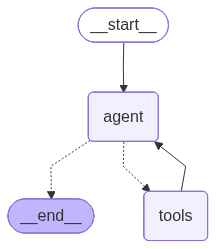

In [38]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)

financial_analyst = create_react_agent(model=chatgpt,
                                       tools=tools,
                                       prompt=SYS_PROMPT)
financial_analyst

In [39]:
def call_financial_analyst_agent(query, verbose=False):

    for event in financial_analyst.stream(
        {"messages": [HumanMessage(content=query)]},
        stream_mode='values' #returns full agent state with all messages including updates
    ):
        if verbose:
            event["messages"][-1].pretty_print()

    print('\n\nFinal Response:\n')
    # display(Markdown(event["messages"][-1].content))

In [9]:
call_financial_analyst_agent(query="Do a comparative analysis between Nvidia and Intel and recommend which one to buy or avoid?",verbose=True)

================================ Human Message =================================

Do a comparative analysis between Nvidia and Intel and recommend which one to buy or avoid?
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_aXafRONQ6ON8KCSVEkkZGVb2)
 Call ID: call_aXafRONQ6ON8KCSVEkkZGVb2
  Args:
    stock_name: Nvidia
  get_stock_ticker_symbol (call_XZGyn2DPe2qbUmCZR2eTe1yf)
 Call ID: call_XZGyn2DPe2qbUmCZR2eTe1yf
  Args:
    stock_name: Intel
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name                                                           |     cik |
|---:|:---------|:---------------------------------------------------------------|--------:|
|  0 | INTC     | INTEL CORP                                                     |   50863 |
|  1 | ZK       | Z

Here's a comparative analysis of Nvidia (NVDA) and Intel (INTC) based on the latest available data:

### Nvidia (NVDA)
- **Current Price**: \$167.03
- **Price Change**: -2.54% over the last day
- **Year High/Low**: \$174.25 / \$86.62
- **Volatility**: Weekly - 2.18%, Monthly - 2.17%
- **Performance**: 
  - 1 Month: +16.11%
  - 3 Months: +72.36%
  - 1 Year: +37.94%
  - 3 Years: +959.70%
  - 5 Years: +1533.19%
  - 10 Years: +33490.75%
- **Volume**: 193,114,327 (below average volume)

### Intel (INTC)
- **Current Price**: \$23.24
- **Price Change**: -0.09% over the last day
- **Year High/Low**: \$33.41 / \$17.67
- **Volatility**: Weekly - 2.77%, Monthly - 3.40%
- **Performance**: 
  - 1 Month: +10.25%
  - 3 Months: +23.35%
  - 1 Year: -33.35%
  - 3 Years: -39.82%
  - 5 Years: -60.63%
  - 10 Years: -21.62%
- **Volume**: 53,226,845 (below average volume)

### Analysis & Recommendation
- **Nvidia** has shown strong performance over the past years, with significant growth in both short and long-term metrics. Its recent price volatility is relatively low, indicating stability.
- **Intel**, on the other hand, has struggled with negative performance over the past years, although it has shown some short-term recovery in the last three months.

### Recommendation
- **Consider Buying Nvidia (NVDA)**: Given its strong historical performance and growth potential, Nvidia appears to be a more promising investment. However, the stock is currently trading near its year high, so consider market conditions and your risk tolerance.
- **Exercise Caution with Intel (INTC)**: While Intel has shown some short-term recovery, its long-term performance has been negative. It may be worth monitoring for further recovery signs before considering an investment.

Please remember to conduct your own research and consider your financial situation and risk tolerance before making any investment decisions.

In [41]:
call_financial_analyst_agent(query="stock info on tesla",verbose=True)

================================ Human Message =================================

stock info on tesla
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_mQ0BNOQkP1diYmfJtkDCddqQ)
 Call ID: call_mQ0BNOQkP1diYmfJtkDCddqQ
  Args:
    stock_name: Tesla
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name        |     cik |
|---:|:---------|:------------|--------:|
|  0 | TSLA     | Tesla, Inc. | 1318605 |
================================== Ai Message ==================================
Tool Calls:
  get_stock_price_metric (call_Cu1UpGHXEFvV0znkTeLXhxwf)
 Call ID: call_Cu1UpGHXEFvV0znkTeLXhxwf
  Args:
    stock_ticker: TSLA
  get_stock_fundamental_indicator_metrics (call_hhmUiz6MJeETFuldNtCjUAuO)
 Call ID: call_hhmUiz6MJeETFuldNtCjUAuO
  Args:
    stock_ticker: TSLA
  get_s